In [1]:
import numpy as np
import pickle
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd

In [3]:
# Loading data
USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS = 950

# Load the pickle file
print("Loading datafile...")
with open(
    "mon_standard.pkl", "rb"
) as fi:  # mon_standard.pkl in directory
    data = pickle.load(fi)

X1 = []  # Array to store instances (timestamps) - 19,000 instances
X2 = []  # Array to store instances (direction*size) - size information
X3 = []  # Array to store instances (cumulative pkt sizes)
X4 = []  # Array to store instances (bursts)
X5 = [] # Array to store time differences
X6 = []  # Array to store instances (standard deviation of packet sizes)
y = []  # Array to store the site of each instance - 19,000 instances

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)

# Feature extraction
pkt_sizes = X2
pkt_timestamps = X1

# Extract cumulative packet sizes
cumulative_pkt_sizes = [np.cumsum(packet_sizes).tolist() for packet_sizes in pkt_sizes]
X3 = cumulative_pkt_sizes

# Extract bursts
bursts = []
for instance in pkt_sizes:
    instance_bursts = []
    current_burst = 0
    current_direction = np.sign(
        instance[0]
    )  # Initialize with the first packet's direction
    for size in instance:
        direction = np.sign(size)
        if direction == current_direction:
            # Accumulate burst size for the same direction
            current_burst += size
        else:
            # Append the completed burst and reset for the new direction
            instance_bursts.append(current_burst)
            current_burst = size
            current_direction = direction
    instance_bursts.append(current_burst)  # Add the last burst
    bursts.append(instance_bursts)
X4 = bursts

# Extract time differences (packet inter-arrival times)
time_differences = []
for timestamps in pkt_timestamps:
    time_diff = np.diff(timestamps).tolist()  # Calculate differences between consecutive timestamps
    time_differences.append(time_diff)
X5 = time_differences

# Extract standard deviation of packet sizes
standard_deviation = [np.std(packet_sizes) for packet_sizes in pkt_sizes]
X6 = standard_deviation

size = len(y)

print(f"Total samples: {size}")  # Output: 19000

Loading datafile...
Total samples: 19000


In [4]:
data_dict = {
    "Timestamps": X1,
    "Direction*Size": X2,
    "Cumulative Sizes": X3,
    "Bursts": X4,
    "Time Differences": X5,
    "Standard Deviation": X6,
    "Site Label": y,
}

# Creating a DataFrame
df = pd.DataFrame(data_dict)

df.head(5)

,Timestamps,Direction*Size,Cumulative Sizes,Bursts,Time Differences,Standard Deviation,Site Label
0,"[0.0, 0.14, 0.14, 0.31, 0.31, 0.51, 0.51, 0.51...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-512, -1024, -512, -1024, -512, -1024, -512, ...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[0.14, 0.0, 0.16999999999999998, 0.0, 0.2, 0.0...",285.805275,0
1,"[0.0, 0.13, 0.13, 0.31, 0.77, 1.11, 1.11, 1.11...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-512, -1024, -512, -1024, -512, -1024, -512, ...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[0.13, 0.0, 0.18, 0.46, 0.3400000000000001, 0....",370.043045,0
2,"[0.0, 0.11, 0.11, 0.23, 0.97, 1.11, 1.11, 1.11...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-512, -1024, -512, -1024, -512, -1024, -512, ...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[0.11, 0.0, 0.12000000000000001, 0.74, 0.14000...",288.437706,0
3,"[0.0, 0.27, 0.27, 0.6, 0.6, 0.88, 0.89, 0.89, ...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-512, -1024, -512, -1024, -512, -1024, -512, ...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[0.27, 0.0, 0.32999999999999996, 0.0, 0.28, 0....",284.613550,0
4,"[0.0, 0.11, 0.11, 0.36, 0.36, 0.6, 0.6, 0.6, 0...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-512, -1024, -512, -1024, -512, -1024, -512, ...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[0.11, 0.0, 0.25, 0.0, 0.24, 0.0, 0.0, 0.24, 0...",280.625206,0


In [5]:
X = df.drop(columns=["Site Label"])
y = df["Site Label"]


In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 고정된 길이 설정 (예: 100)
fixed_length = 100

# 리스트 데이터를 고정된 길이로 패딩하거나 잘라내기
def pad_or_truncate(lst, length):
    # If the input is not iterable (e.g., a float), convert it to a list
    if not isinstance(lst, (list, np.ndarray)):
        lst = [lst]  # Convert scalar to list
    return lst[:length] + [0] * max(0, length - len(lst))

# 각 칼럼에 대해 적용
X_timestamps = np.array([pad_or_truncate(x, fixed_length) for x in df["Timestamps"]])
X_direction_size = np.array(
    [pad_or_truncate(x, fixed_length) for x in df["Direction*Size"]]
)
X_cumulative_sizes = np.array(
    [pad_or_truncate(x, fixed_length) for x in df["Cumulative Sizes"]]
)
X_bursts = np.array([pad_or_truncate(x, fixed_length) for x in df["Bursts"]])
X_time_differences = np.array(
    [pad_or_truncate(x, fixed_length) for x in df["Time Differences"]]
)
X_standard_deviation = np.array(
    [pad_or_truncate(x, fixed_length) for x in df["Standard Deviation"]]
)

# StandardScaler 적용
scaler = StandardScaler()
X_timestamps_scaled = scaler.fit_transform(X_timestamps)
X_direction_size_scaled = scaler.fit_transform(X_direction_size)
X_cumulative_sizes_scaled = scaler.fit_transform(X_cumulative_sizes)
X_bursts_scaled = scaler.fit_transform(X_bursts)
X_time_differences_scaled = scaler.fit_transform(X_time_differences)
X_standard_deviation_scaled = scaler.fit_transform(X_standard_deviation)

# 스케일링된 데이터 결합
X_combined = np.hstack([
    X_timestamps_scaled,
    X_direction_size_scaled,
    X_cumulative_sizes_scaled,
    X_bursts_scaled,
    X_time_differences_scaled,
    X_standard_deviation_scaled,
])
print(X_combined)

[[ 0.         -0.1169824  -0.11789155 ...  0.          0.
   0.        ]
 [ 0.         -0.14119075 -0.14209979 ...  0.          0.
   0.        ]
 [ 0.         -0.18960746 -0.19051626 ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.18960746 -0.19051626 ...  0.          0.
   0.        ]
 [ 0.         -0.04435735 -0.04526685 ...  0.          0.
   0.        ]
 [ 0.         -0.1653991  -0.16630802 ...  0.          0.
   0.        ]]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# 랜덤 포레스트 모델 정의 (트리 개수와 최대 깊이를 설정할 수 있음)
rf_clf = RandomForestClassifier(
    n_estimators=500, criterion="entropy", random_state=42
)  # n_estimators = 500

# 모델 학습
rf_clf.fit(X_train, y_train)

# 테스트 세트로 예측
y_pred_rf = rf_clf.predict(X_test)

# 정확도 평가
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Random Forest with Boosting
boosted_rf = AdaBoostClassifier(estimator=rf_clf, n_estimators=50, random_state=42)
boosted_rf.fit(X_train, y_train)
y_pred_boosted_rf = boosted_rf.predict(X_test)
print("Boosted Random Forest Accuracy:", accuracy_score(y_test, y_pred_boosted_rf))
    

Random Forest Accuracy: 0.9018
Boosted Random Forest Accuracy: 0.9018421052631579


In [9]:
#Comparing with gini

rf_gini = RandomForestClassifier(criterion='gini', random_state=42)
rf_gini.fit(X_train, y_train)
y_pred_gini = rf_gini.predict(X_test)
print("Random Forest Gini Accuracy:", accuracy_score(y_test, y_pred_gini))

Random Forest Gini Accuracy: 0.8981578947368422


In [10]:
from sklearn.metrics import accuracy_score, classification_report

report = classification_report(y_test, y_pred_rf)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        42
           1       1.00      0.88      0.94        42
           2       0.89      0.97      0.93        35
           3       0.92      0.83      0.87        29
           4       0.92      0.92      0.92        39
           5       0.95      0.91      0.93        45
           6       1.00      0.98      0.99        44
           7       0.77      0.75      0.76        36
           8       0.94      0.85      0.89        34
           9       0.48      0.68      0.56        31
          10       0.98      0.89      0.93        47
          11       0.92      0.94      0.93        35
          12       0.93      0.95      0.94        42
          13       0.88      0.93      0.90        40
          14       0.97      0.97      0.97        36
          15       0.88      0.86      0.87        35
          16       0.97      0.79      0.87        43
    

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [20, 50, 100, 200, 500],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_accuracy = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_accuracy}")

y_pred_best = best_model.predict(X_test)
test_accuracy_best = accuracy_score(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

print(f"Test Accuracy (Best Model): {test_accuracy_best}")
print("Confusion Matrix (Best Model):")
print(conf_matrix_best)

Best Parameters: {'criterion': 'entropy', 'n_estimators': 500}
Best Cross-Validation Accuracy: 0.9001973684210526
Test Accuracy (Best Model): 0.9018421052631579
Confusion Matrix (Best Model):
[[38  0  0 ...  0  0  0]
 [ 0 37  0 ...  0  0  0]
 [ 0  0 34 ...  0  0  0]
 ...
 [ 0  0  0 ... 34  0  0]
 [ 0  0  0 ...  0 38  0]
 [ 2  0  0 ...  0  0 37]]


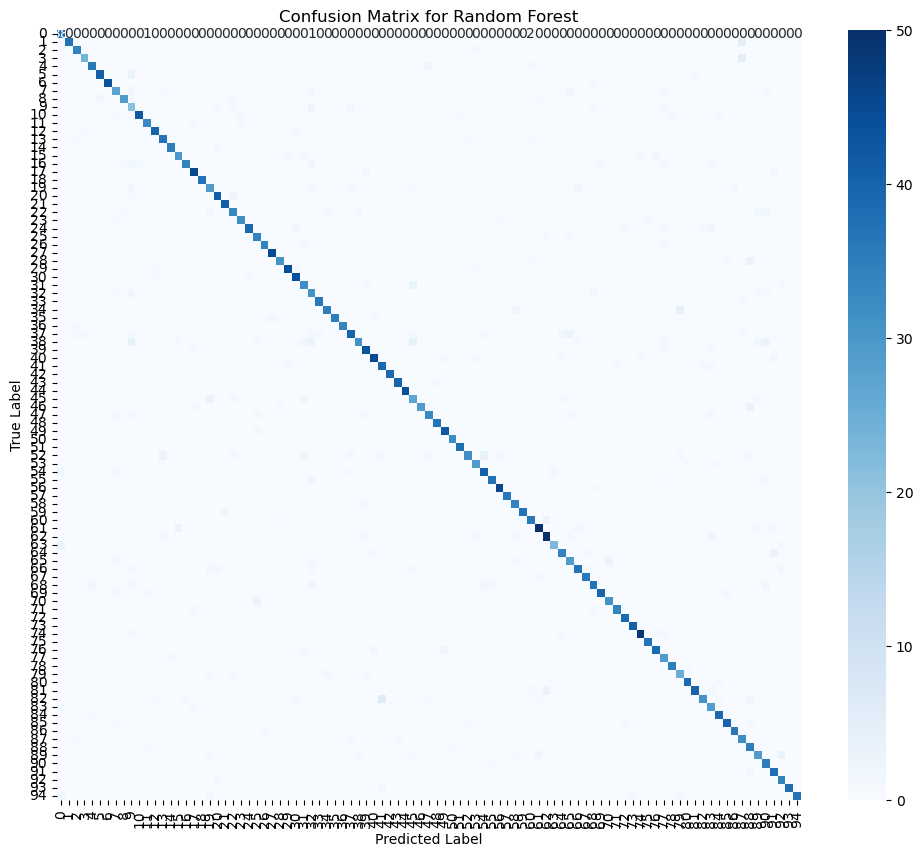

In [14]:
# Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


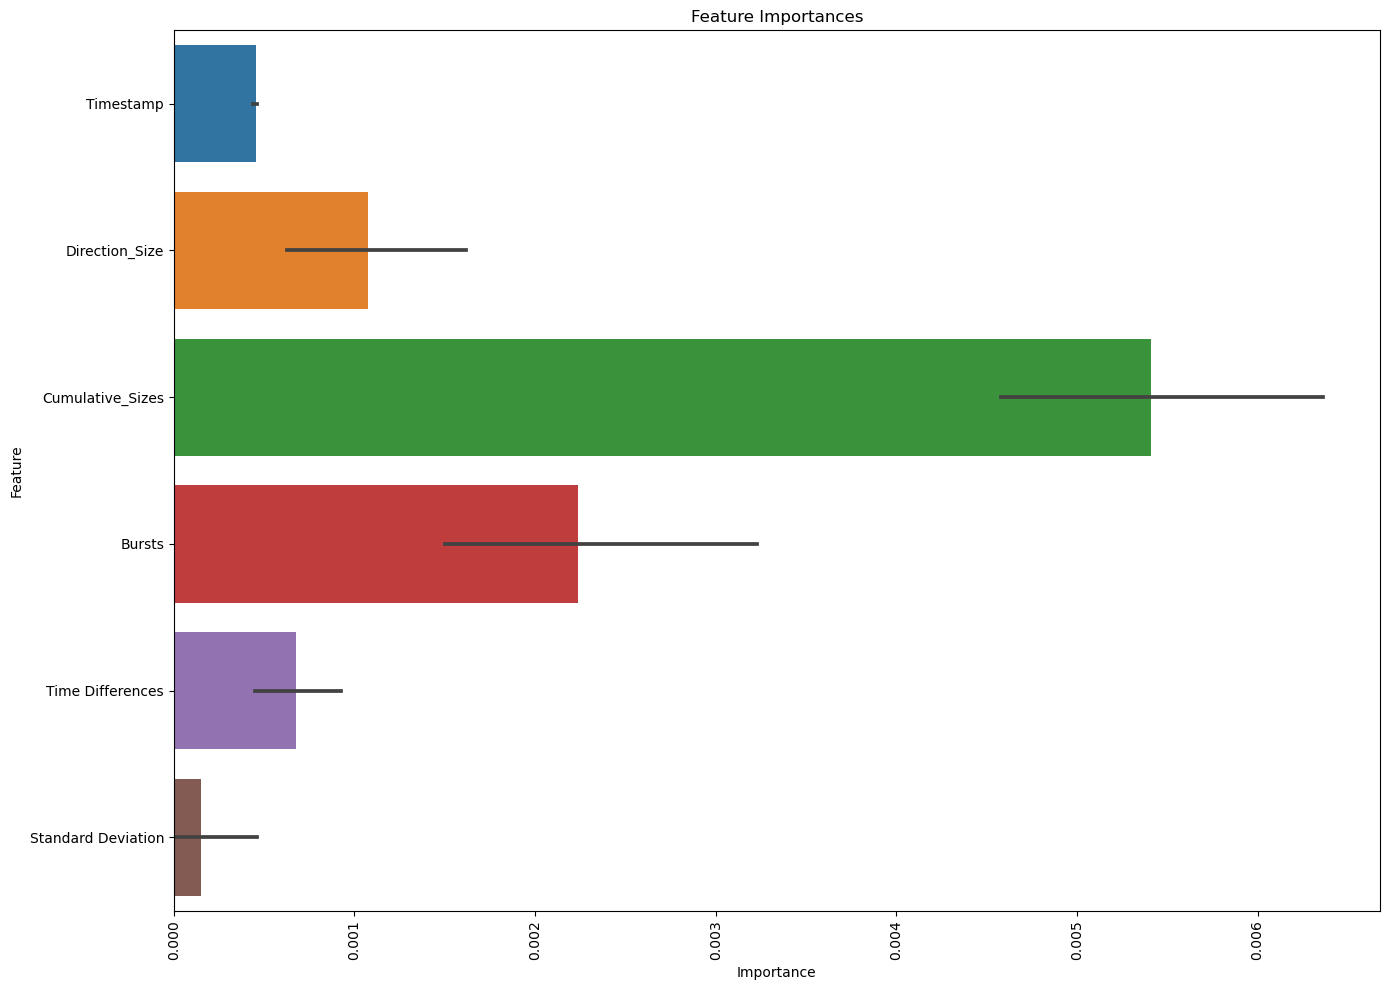

In [15]:
# FEATURE IMPORTANCE PLOT
feature_importances = rf_clf.feature_importances_

# Correct the feature names for the Feature Importance Plot
flattened_feature_names = ['Timestamp'] * fixed_length + ['Direction_Size'] * fixed_length + ['Cumulative_Sizes'] * fixed_length + ['Bursts'] * fixed_length + ['Time Differences'] * fixed_length+ ['Standard Deviation'] * fixed_length

plt.figure(figsize=(14, 10))
sns.barplot(x=feature_importances, y=flattened_feature_names)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# Linear SVM
svc_linear = SVC(kernel='linear', random_state=42)
svc_linear.fit(X_train, y_train)
y_pred_svm = svc_linear.predict(X_test)
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
    

Linear SVM Accuracy: 0.8863157894736842


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Pipeline for scaling and SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1, random_state=42))
])

# Fit and predict
pipeline_svm.fit(X_train, y_train)
y_pred_enhanced_svm = pipeline_svm.predict(X_test)

# Accuracy
print("Enhanced Linear SVM Accuracy:", accuracy_score(y_test, y_pred_enhanced_svm))


Enhanced Linear SVM Accuracy: 0.8843859649122807
